In [1]:
import torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install ogb  # for datasets

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-mb5olrk5
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-mb5olrk5
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit cd188588ac956d42345d16ad9d2d8ac8bc11b4b2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
pip install cython

In [3]:
%load_ext cython

In [4]:
import os
import yaml
from tqdm import tqdm
import argparse
from time import time
import numpy as np
import logging
import random
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

### Importing OGB dataset
from ogb.graphproppred.dataset_pyg import PygGraphPropPredDataset
from ogb.graphproppred import Evaluator
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool
from torch_geometric.utils import add_self_loops, degree

In [5]:
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
print(device)

cuda


In [6]:
import torch.nn as nn

class MLPWithOneHotOutput(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPWithOneHotOutput, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return torch.softmax(x, dim=1)


class GIN_with_attention(MessagePassing):
    def __init__(self, emb):
        super(GIN_with_attention, self).__init__(aggr = "add")

        self.mlp = MLPWithOneHotOutput(emb, 2*emb, emb)
        self.eps = torch.nn.Parameter(torch.Tensor([0]))
        self.bond_encoder = BondEncoder(emb_dim = emb)
        self.attention = torch.nn.Sequential(
            nn.Linear(emb, 2 * emb),
            nn.LeakyReLU(),
            nn.Linear(2 * emb, 1)
        )

    def forward(self, x, edge_index, edge_attr):
        edge_embedding = self.bond_encoder(edge_attr)
        attention_weights = F.softmax(self.attention(edge_embedding), dim=0)
        out = self.mlp((1 + self.eps) *x + self.propagate(edge_index, x=x, edge_attr=edge_embedding, attention_weights = attention_weights))
        return out

    def message(self, x_j, edge_attr, attention_weights):
        return F.relu(x_j + edge_attr) * attention_weights

    def update(self, aggr_out):
        return aggr_out


class GIN(MessagePassing):
    def __init__(self, emb):
        super(GIN, self).__init__(aggr = "add")

        self.mlp = MLPWithOneHotOutput(emb, 2*emb, emb)
        self.eps = torch.nn.Parameter(torch.Tensor([0]))
        self.bond_encoder = BondEncoder(emb_dim = emb)

    def forward(self, x, edge_index, edge_attr):
        edge_embedding = self.bond_encoder(edge_attr)
        out = self.mlp((1 + self.eps) *x + self.propagate(edge_index, x=x, edge_attr=edge_embedding))
        return out

    def message(self, x_j, edge_attr):
        return F.relu(x_j + edge_attr)

    def update(self, aggr_out):
        return aggr_out

class GNN_node(torch.nn.Module):
    def __init__(self, num_layer, emb_dim, gnn_type = 'gin', drop_ratio = 0.5):
        super(GNN_node, self).__init__()
        self.num_layer = num_layer

        if self.num_layer < 2:
            raise ValueError("Number of GIN layers should be greater than 1")

        self.atom_encoder = AtomEncoder(emb_dim)

        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        self.drop_ratio = drop_ratio
        for layer in range(num_layer):
            if gnn_type == 'gin':
              self.convs.append(GIN(emb_dim))
            else:
              self.convs.append(GIN_with_attention(emb_dim))
            self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))

    def forward(self, batched_data):
        x, edge_index, edge_attr, batch = batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.batch

        node_emb = self.atom_encoder(x)
        for layer in range(self.num_layer):
            h = self.convs[layer](node_emb, edge_index, edge_attr)
            h = self.batch_norms[layer](h)
            if layer == self.num_layer - 1:
                h = F.dropout(h, self.drop_ratio, training = self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)
            node_emb= h
        return node_emb

class GNN(torch.nn.Module):

    def __init__(self, num_tasks, num_layer = 2, emb_dim = 300, gnn_type = 'gin', graph_pooling = "mean"):
        super(GNN, self).__init__()

        self.num_layer = num_layer
        self.emb_dim = emb_dim
        self.num_tasks = num_tasks
        self.graph_pooling = graph_pooling

        if self.num_layer < 2:
            raise ValueError("Number of layers should be greater than 1.")

        self.gnn_node = GNN_node(num_layer, emb_dim, gnn_type)


        if self.graph_pooling == "sum":
            self.pool = global_add_pool
        elif self.graph_pooling == "mean":
            self.pool = global_mean_pool
        elif self.graph_pooling == "max":
            self.pool = global_max_pool
        else:
            raise ValueError("Invalid graph pooling type.")

        self.graph_pred_linear = torch.nn.Linear(self.emb_dim, self.num_tasks)

    def forward(self, batched_data):
        h_node = self.gnn_node(batched_data)

        h_graph = self.pool(h_node, batched_data.batch)

        return self.graph_pred_linear(h_graph)

In [7]:
def train(epoch, model, device, loader, optimizer, task_type):
    model.train()
    clf_criterion = torch.nn.BCEWithLogitsLoss()
    reg_criterion = torch.nn.MSELoss()
    loss_list = []
    epoch_iter = tqdm(loader)
    for step, batch in enumerate(epoch_iter):
        batch = batch.to(device)

        if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
            pass
        else:
            pred = model(batch)
            optimizer.zero_grad()
            ## ignore nan targets (unlabeled) when computing training loss.
            mask = ~torch.isnan(batch.y)
            y_true = batch.y[mask]
            y_pred = pred[mask]
            if "classification" in task_type:
                loss = clf_criterion(y_pred, y_true.float())
            else:
                loss = reg_criterion(y_pred, y_true.float())
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            epoch_iter.set_description(f"epoch: {epoch}, train_loss: {loss:.4f}")
    return np.mean(loss_list)

def test(model, device, loader, evaluator):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader)):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            pred = model(batch)
            y_true.append(batch.y.view(pred.shape).detach().cpu())
            y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()
    input_dict = {"y_true": y_true, "y_pred": y_pred}

    return evaluator.eval(input_dict)

In [8]:
## Code to train model on a particular task
def train_model_on_task(task_name, gnn_type='gin', lr=0.001, num_epochs=20, batch_size=32):
    device = get_default_device()
    s = time()

    ## Load dataset and evaluator
    dataset = PygGraphPropPredDataset(name=task_name)
    evaluator = Evaluator(task_name)
    split_idx = dataset.get_idx_split()


    ## Make the split dataloaders
    train_loader = DataLoader(dataset[split_idx["train"]], batch_size=batch_size, shuffle=True, num_workers = 1)
    valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=batch_size, shuffle=False, num_workers = 1)
    test_loader = DataLoader(dataset[split_idx["test"]], batch_size=batch_size, shuffle=False, num_workers = 1)

    ## Define model and optimizers
    model = GNN(num_tasks= dataset.num_tasks, gnn_type=gnn_type)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_curve = []
    valid_curve = []
    test_curve = []
    train_val_curve = []

    ## Train the model and store loss/metrics
    for epoch in range(1, num_epochs + 1):
        train_perf = train(epoch, model, device, train_loader, optimizer, dataset.task_type)
        valid_perf = test(model, device, valid_loader, evaluator)
        test_perf = test(model, device, test_loader, evaluator)
        print({'Train Loss': train_perf, 'Validation Metric': valid_perf, 'Test Metric': test_perf})
        train_curve.append(train_perf)
        valid_curve.append(valid_perf[dataset.eval_metric])
        test_curve.append(test_perf[dataset.eval_metric])
    if 'classification' in dataset.task_type:
        ## For classification metrics, the higher the better
        best_val_epoch = np.argmax(np.array(valid_curve))
    else:
        ## For regression metrics, the lower the better
        best_val_epoch = np.argmin(np.array(valid_curve))

    curves = {"train": train_curve, "valid": valid_curve, "test": test_curve}
    print('Best Validation Metric: {}'.format(valid_curve[best_val_epoch]))
    print('Test Metric: {}'.format(test_curve[best_val_epoch]))
    return valid_curve[best_val_epoch], test_curve[best_val_epoch], curves, model

In [9]:
def plot_curves(curves):
    epochs = range(1, len(curves["train"]) + 1)

    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, curves["train"], label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()

    # Plot validation and test metrics
    plt.subplot(1, 2, 2)
    plt.plot(epochs, curves["valid"], label='Validation Metric', color='orange')
    plt.plot(epochs, curves["test"], label='Test Metric', color='green')
    plt.title('Validation and Test Metrics over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()

100%|██████████| 129/129 [00:11<00:00, 10.89it/s]


{'Train Loss': 0.1772316987377359, 'Validation Metric': {'rocauc': 0.6235409930433078}, 'Test Metric': {'rocauc': 0.6439125900461578}}


100%|██████████| 129/129 [00:10<00:00, 12.74it/s]


{'Train Loss': 0.15773806918821542, 'Validation Metric': {'rocauc': 0.54716741377621}, 'Test Metric': {'rocauc': 0.5333919156414763}}


100%|██████████| 129/129 [00:09<00:00, 14.25it/s]


{'Train Loss': 0.15889048720261967, 'Validation Metric': {'rocauc': 0.6086018640995492}, 'Test Metric': {'rocauc': 0.6055958979509066}}


100%|██████████| 129/129 [00:09<00:00, 12.99it/s]


{'Train Loss': 0.1580602921911156, 'Validation Metric': {'rocauc': 0.6181443513619439}, 'Test Metric': {'rocauc': 0.6370797041271559}}


100%|██████████| 129/129 [00:09<00:00, 14.01it/s]


{'Train Loss': 0.15805786302488795, 'Validation Metric': {'rocauc': 0.6652489956888105}, 'Test Metric': {'rocauc': 0.5934490816740376}}
Best Validation Metric: 0.6652489956888105
Test Metric: 0.5934490816740376


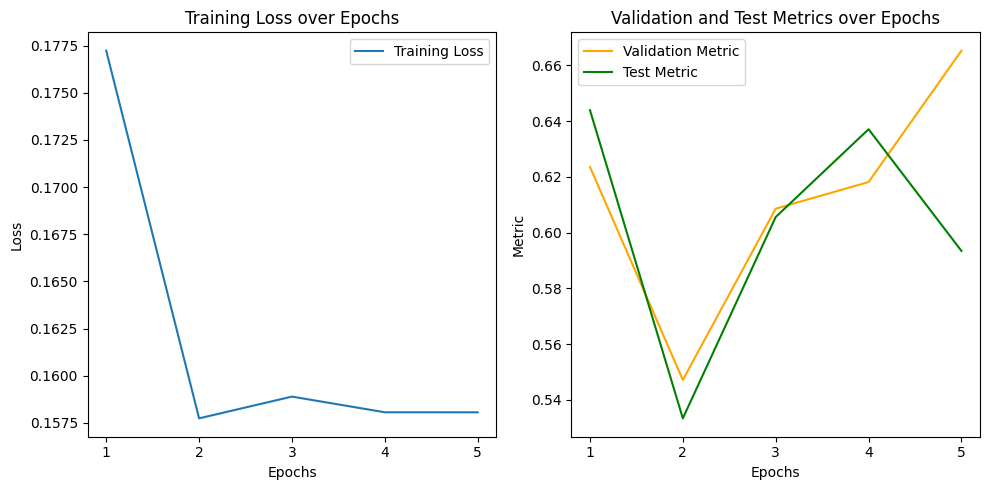

100%|██████████| 129/129 [00:08<00:00, 15.10it/s]


{'Train Loss': 0.17844200738867702, 'Validation Metric': {'rocauc': 0.644579475308642}, 'Test Metric': {'rocauc': 0.657203692616698}}


100%|██████████| 129/129 [00:09<00:00, 13.05it/s]


{'Train Loss': 0.15950707847974738, 'Validation Metric': {'rocauc': 0.5975712815990594}, 'Test Metric': {'rocauc': 0.5950433573456421}}


100%|██████████| 129/129 [00:09<00:00, 12.94it/s]


{'Train Loss': 0.1590734696897259, 'Validation Metric': {'rocauc': 0.5422055653537134}, 'Test Metric': {'rocauc': 0.6125185886170068}}


100%|██████████| 129/129 [00:08<00:00, 15.39it/s]


{'Train Loss': 0.15913570706485486, 'Validation Metric': {'rocauc': 0.581731946893984}, 'Test Metric': {'rocauc': 0.617450124567875}}


100%|██████████| 129/129 [00:09<00:00, 14.10it/s]


{'Train Loss': 0.15816150245820584, 'Validation Metric': {'rocauc': 0.6481588648834019}, 'Test Metric': {'rocauc': 0.532202244153035}}
Best Validation Metric: 0.6481588648834019
Test Metric: 0.532202244153035


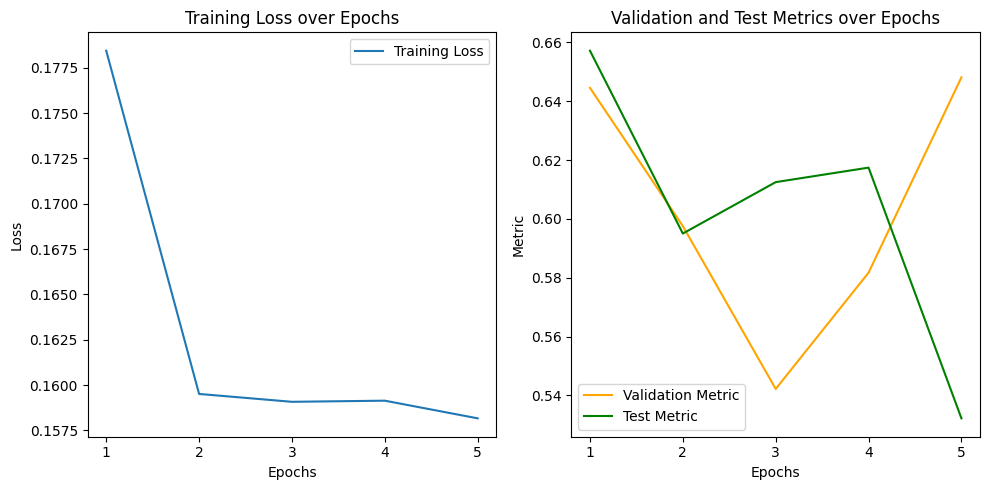

100%|██████████| 129/129 [00:09<00:00, 12.99it/s]


{'Train Loss': 0.17761061084434115, 'Validation Metric': {'rocauc': 0.5803004972565158}, 'Test Metric': {'rocauc': 0.6368180150253964}}


100%|██████████| 129/129 [00:09<00:00, 13.11it/s]


{'Train Loss': 0.15762189062143903, 'Validation Metric': {'rocauc': 0.514210390946502}, 'Test Metric': {'rocauc': 0.574467448193283}}


100%|██████████| 129/129 [00:10<00:00, 12.74it/s]


{'Train Loss': 0.15715634090096425, 'Validation Metric': {'rocauc': 0.5253068048206937}, 'Test Metric': {'rocauc': 0.5741536143996601}}


100%|██████████| 129/129 [00:10<00:00, 12.81it/s]


{'Train Loss': 0.15650607069702666, 'Validation Metric': {'rocauc': 0.5730146482461298}, 'Test Metric': {'rocauc': 0.6150843005851794}}


100%|██████████| 129/129 [00:09<00:00, 14.25it/s]


{'Train Loss': 0.1565902927913952, 'Validation Metric': {'rocauc': 0.6292040221438369}, 'Test Metric': {'rocauc': 0.5992728712412368}}
Best Validation Metric: 0.6292040221438369
Test Metric: 0.5992728712412368


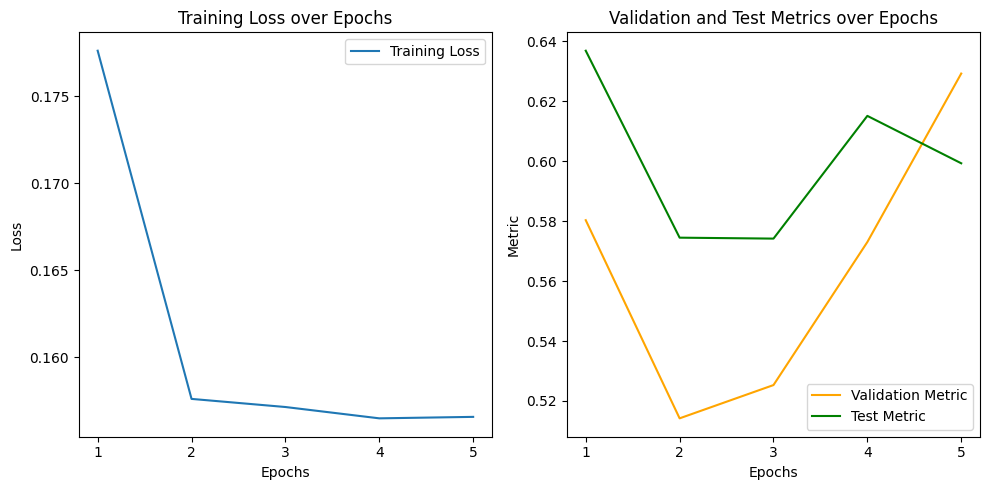

In [33]:
task_name = "ogbg-molhiv"
gnn_type = 'gin'
for i in range(3):
  val_metric_gnn, test_metric_gnn, curves_gnn, model_gnn = train_model_on_task(task_name, gnn_type = gnn_type, num_epochs = 5)
  plot_curves(curves_gnn)

100%|██████████| 129/129 [00:13<00:00,  9.32it/s]


{'Train Loss': 0.17491570188400524, 'Validation Metric': {'rocauc': 0.5767593817362335}, 'Test Metric': {'rocauc': 0.6584310241603739}}


100%|██████████| 129/129 [00:13<00:00,  9.46it/s]


{'Train Loss': 0.1548105515286225, 'Validation Metric': {'rocauc': 0.6490391681363903}, 'Test Metric': {'rocauc': 0.6716728789663763}}


100%|██████████| 129/129 [00:17<00:00,  7.58it/s]


{'Train Loss': 0.15318120199466528, 'Validation Metric': {'rocauc': 0.6791929992161474}, 'Test Metric': {'rocauc': 0.6718457289634795}}


100%|██████████| 129/129 [00:13<00:00,  9.44it/s]


{'Train Loss': 0.15734966874911846, 'Validation Metric': {'rocauc': 0.48202803497942387}, 'Test Metric': {'rocauc': 0.5661107785009368}}


100%|██████████| 129/129 [00:12<00:00,  9.94it/s]


{'Train Loss': 0.16051377292516106, 'Validation Metric': {'rocauc': 0.5896883573388202}, 'Test Metric': {'rocauc': 0.622175013036173}}
Best Validation Metric: 0.6791929992161474
Test Metric: 0.6718457289634795


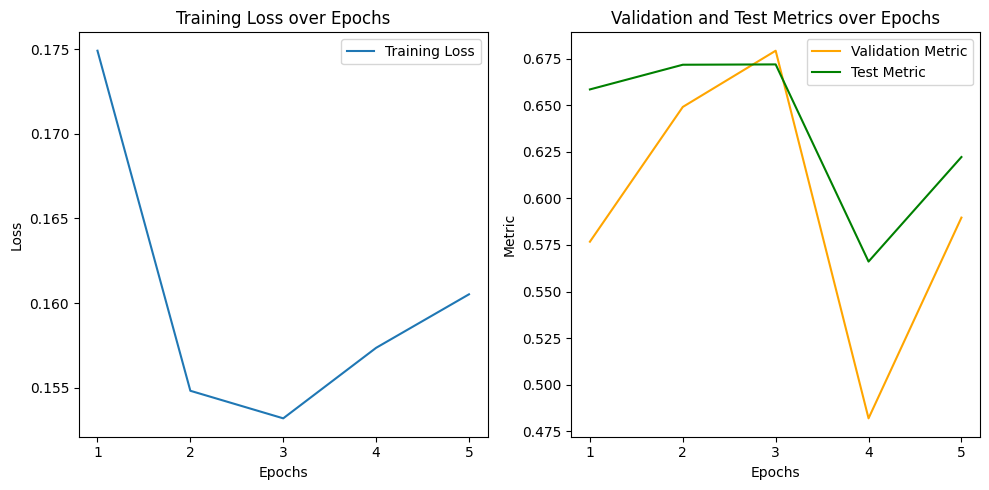

100%|██████████| 129/129 [00:14<00:00,  8.90it/s]


{'Train Loss': 0.1777807420175758, 'Validation Metric': {'rocauc': 0.6023172643543013}, 'Test Metric': {'rocauc': 0.6367938739643485}}


100%|██████████| 129/129 [00:14<00:00,  9.03it/s]


{'Train Loss': 0.15571732058092966, 'Validation Metric': {'rocauc': 0.6287248309817755}, 'Test Metric': {'rocauc': 0.6051999845497209}}


100%|██████████| 129/129 [00:14<00:00,  8.77it/s]


{'Train Loss': 0.15516049734364734, 'Validation Metric': {'rocauc': 0.6561504874583579}, 'Test Metric': {'rocauc': 0.6736389269781186}}


100%|██████████| 129/129 [00:14<00:00,  9.00it/s]


{'Train Loss': 0.15211583014335067, 'Validation Metric': {'rocauc': 0.6723189790319419}, 'Test Metric': {'rocauc': 0.6769520461963344}}


100%|██████████| 129/129 [00:14<00:00,  9.15it/s]


{'Train Loss': 0.15193427509408303, 'Validation Metric': {'rocauc': 0.6485416054281796}, 'Test Metric': {'rocauc': 0.6576459568550956}}
Best Validation Metric: 0.6723189790319419
Test Metric: 0.6769520461963344


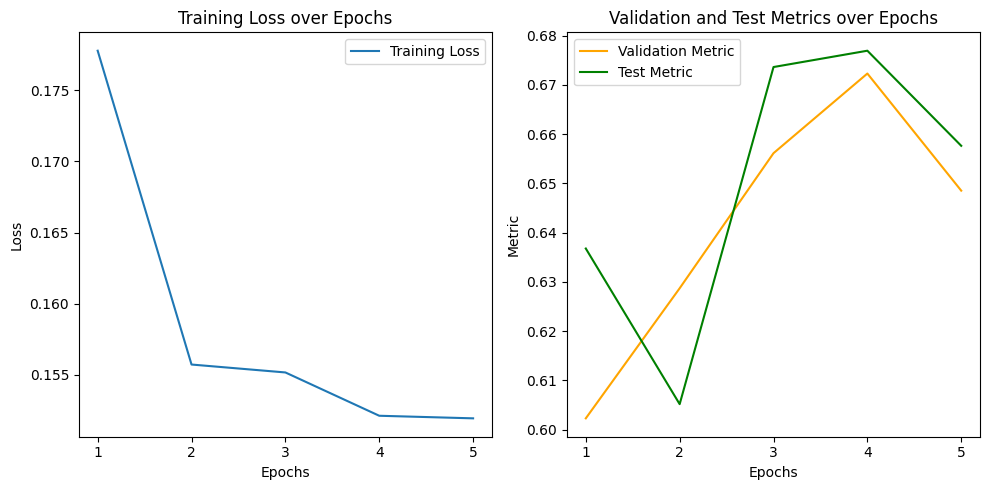

100%|██████████| 129/129 [00:14<00:00,  9.19it/s]


{'Train Loss': 0.17750034429697706, 'Validation Metric': {'rocauc': 0.6700684646286499}, 'Test Metric': {'rocauc': 0.688084937909191}}


100%|██████████| 129/129 [00:14<00:00,  8.73it/s]


{'Train Loss': 0.15643541959989582, 'Validation Metric': {'rocauc': 0.6371068489124045}, 'Test Metric': {'rocauc': 0.6813447536646131}}


100%|██████████| 129/129 [00:14<00:00,  8.94it/s]


{'Train Loss': 0.15975353595835995, 'Validation Metric': {'rocauc': 0.46060681216931215}, 'Test Metric': {'rocauc': 0.45788157361092335}}


100%|██████████| 129/129 [00:15<00:00,  8.07it/s]


{'Train Loss': 0.15997213668998175, 'Validation Metric': {'rocauc': 0.5195764133842837}, 'Test Metric': {'rocauc': 0.5845004731647966}}


100%|██████████| 129/129 [00:14<00:00,  9.01it/s]


{'Train Loss': 0.15916924388577802, 'Validation Metric': {'rocauc': 0.5314321844993142}, 'Test Metric': {'rocauc': 0.6018269955001062}}
Best Validation Metric: 0.6700684646286499
Test Metric: 0.688084937909191


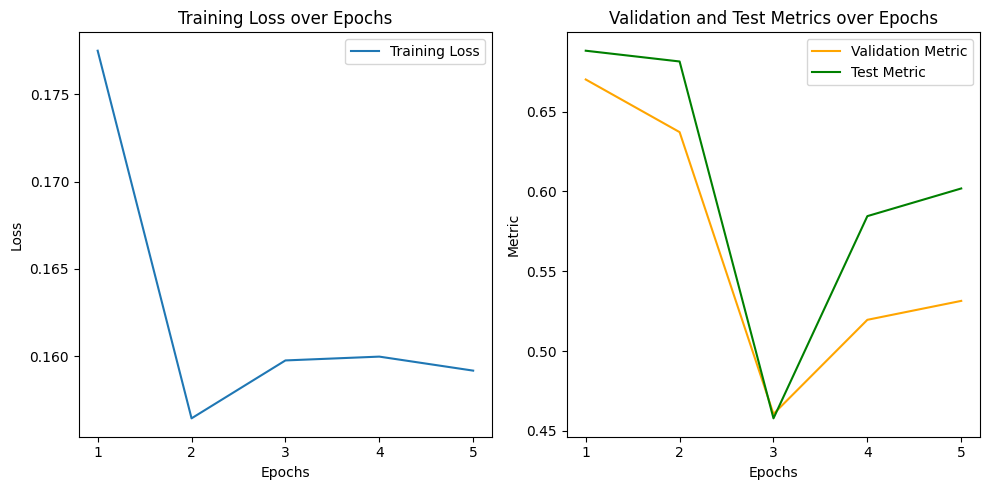

In [40]:
task_name = "ogbg-molhiv"
gnn_type = 'gin_attention'
for i in range(3):
  val_metric_gin_at, test_metric_gin_at, curves_gin_at, model_gin_at = train_model_on_task(task_name, gnn_type = gnn_type, num_epochs = 5)
  plot_curves(curves_gin_at)

In [43]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model_gin_at)

+------------------------------------------------------------+------------+
|                          Modules                           | Parameters |
+------------------------------------------------------------+------------+
|     gnn_node.atom_encoder.atom_embedding_list.0.weight     |   35700    |
|     gnn_node.atom_encoder.atom_embedding_list.1.weight     |    1500    |
|     gnn_node.atom_encoder.atom_embedding_list.2.weight     |    3600    |
|     gnn_node.atom_encoder.atom_embedding_list.3.weight     |    3600    |
|     gnn_node.atom_encoder.atom_embedding_list.4.weight     |    3000    |
|     gnn_node.atom_encoder.atom_embedding_list.5.weight     |    1800    |
|     gnn_node.atom_encoder.atom_embedding_list.6.weight     |    1800    |
|     gnn_node.atom_encoder.atom_embedding_list.7.weight     |    600     |
|     gnn_node.atom_encoder.atom_embedding_list.8.weight     |    600     |
|                    gnn_node.convs.0.eps                    |     1      |
|           

1145705

In [48]:
dataset = PygGraphPropPredDataset(name="ogbg-molhiv")

In [72]:
print(dataset[0].edge_index.shape[1])

40


In [73]:
num_nodes = []
num_edge = []
for i in range(len(dataset)):
  num_nodes.append(dataset[i].num_nodes)
  num_edge.append(dataset[i].edge_index.shape[1]/2)

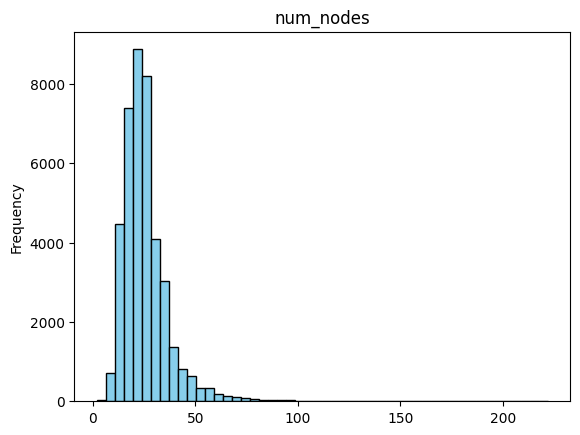

In [69]:
import matplotlib.pyplot as plt

# Load the first graph in the dataset

# Create a histogram for the edge attributes
plt.hist(num_nodes, bins=50, color='skyblue', edgecolor='black')

plt.title(f'num_nodes')
plt.ylabel('Frequency')
plt.show()

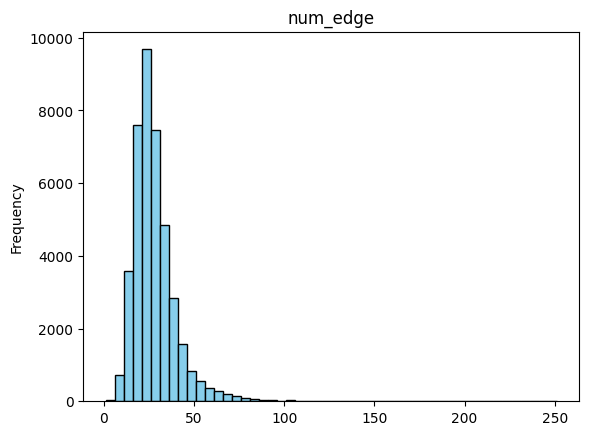

In [75]:
plt.hist(num_edge, bins=50, color='skyblue', edgecolor='black')

plt.title(f'num_edge')
plt.ylabel('Frequency')
plt.show()

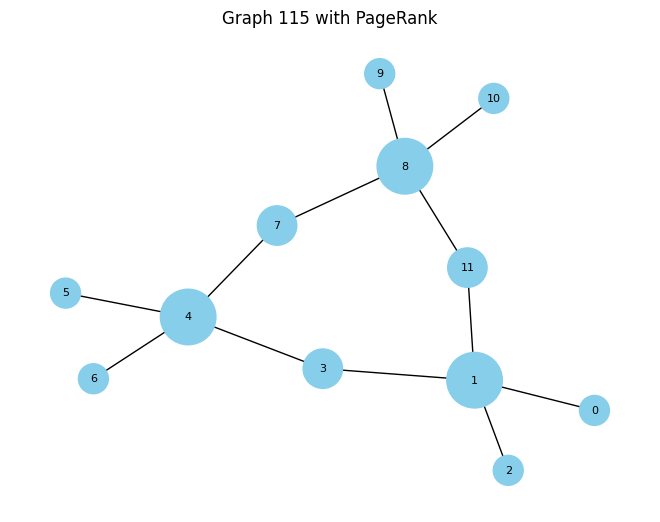

In [77]:
import networkx as nx

# Load the first graph in the dataset
graph_idx = 115
edge_index = dataset[graph_idx].edge_index
edge_attr = dataset[graph_idx].edge_attr
x = dataset[graph_idx].x
y = dataset[graph_idx].y
num_nodes = dataset[graph_idx].num_nodes

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with features
for i in range(num_nodes):
    G.add_node(i, features=x[i].numpy())

# Add edges with features
for j in range(edge_index.shape[1]):
    src, dst = edge_index[0, j].item(), edge_index[1, j].item()
    G.add_edge(src, dst, features=edge_attr[j])

# Calculate PageRank
pagerank = nx.pagerank(G)

# Visualize the graph with node sizes proportional to PageRank
pos = nx.spring_layout(G)
node_sizes = [pagerank[node] * 10000 for node in G.nodes]
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color="skyblue", font_size=8, font_color="black")
plt.title(f"Graph {graph_idx} with PageRank")
plt.show()

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 95931.61it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:01<00:00, 21889.73it/s]


Saving...


Done!
100%|██████████| 129/129 [00:02<00:00, 52.07it/s]


{'Train Loss': 0.17703333827399942, 'Validation Metric': {'rocauc': 0.6223667450519303}, 'Test Metric': {'rocauc': 0.6512572664593754}}


100%|██████████| 129/129 [00:02<00:00, 46.75it/s]


{'Train Loss': 0.1546905082175318, 'Validation Metric': {'rocauc': 0.6850627082108565}, 'Test Metric': {'rocauc': 0.667288862280075}}


100%|██████████| 129/129 [00:02<00:00, 52.86it/s]


{'Train Loss': 0.15338088343584272, 'Validation Metric': {'rocauc': 0.6464916470703508}, 'Test Metric': {'rocauc': 0.6486944514185289}}


100%|██████████| 129/129 [00:02<00:00, 43.06it/s]


{'Train Loss': 0.15277435500591097, 'Validation Metric': {'rocauc': 0.6680016656868508}, 'Test Metric': {'rocauc': 0.6653092952741458}}


100%|██████████| 129/129 [00:02<00:00, 53.71it/s]


{'Train Loss': 0.15106665704714314, 'Validation Metric': {'rocauc': 0.6951793062904172}, 'Test Metric': {'rocauc': 0.6815340195832287}}


100%|██████████| 129/129 [00:03<00:00, 41.39it/s]


{'Train Loss': 0.14981673319214925, 'Validation Metric': {'rocauc': 0.7099377816970409}, 'Test Metric': {'rocauc': 0.6925635875548002}}


100%|██████████| 129/129 [00:02<00:00, 52.57it/s]


{'Train Loss': 0.1488849570715856, 'Validation Metric': {'rocauc': 0.6796737213403881}, 'Test Metric': {'rocauc': 0.6322891519728074}}


100%|██████████| 129/129 [00:02<00:00, 43.29it/s]


{'Train Loss': 0.14877892721288696, 'Validation Metric': {'rocauc': 0.7104644326866549}, 'Test Metric': {'rocauc': 0.6604675640703761}}


100%|██████████| 129/129 [00:02<00:00, 53.08it/s]


{'Train Loss': 0.14827357475311867, 'Validation Metric': {'rocauc': 0.7036455271408975}, 'Test Metric': {'rocauc': 0.6905183568628208}}


100%|██████████| 129/129 [00:02<00:00, 52.56it/s]


{'Train Loss': 0.14790930927154564, 'Validation Metric': {'rocauc': 0.6665901185577112}, 'Test Metric': {'rocauc': 0.7121757855501264}}


100%|██████████| 129/129 [00:02<00:00, 53.39it/s]


{'Train Loss': 0.1478043444802219, 'Validation Metric': {'rocauc': 0.6874938761512835}, 'Test Metric': {'rocauc': 0.6989725564418007}}


100%|██████████| 129/129 [00:02<00:00, 53.62it/s]


{'Train Loss': 0.14795162196228584, 'Validation Metric': {'rocauc': 0.6759810405643739}, 'Test Metric': {'rocauc': 0.691325633944263}}


100%|██████████| 129/129 [00:02<00:00, 47.74it/s]


{'Train Loss': 0.1474525242160546, 'Validation Metric': {'rocauc': 0.709438688026651}, 'Test Metric': {'rocauc': 0.7032571119565847}}


100%|██████████| 129/129 [00:02<00:00, 49.72it/s]


{'Train Loss': 0.14727781784509836, 'Validation Metric': {'rocauc': 0.6788577184989221}, 'Test Metric': {'rocauc': 0.6941655883659399}}


100%|██████████| 129/129 [00:02<00:00, 46.24it/s]


{'Train Loss': 0.1465066705239381, 'Validation Metric': {'rocauc': 0.7189796443268666}, 'Test Metric': {'rocauc': 0.6892552965487939}}


100%|██████████| 129/129 [00:02<00:00, 53.21it/s]


{'Train Loss': 0.14691196635466855, 'Validation Metric': {'rocauc': 0.7116861405055849}, 'Test Metric': {'rocauc': 0.6864810058131675}}


100%|██████████| 129/129 [00:03<00:00, 42.48it/s]


{'Train Loss': 0.1460729963132574, 'Validation Metric': {'rocauc': 0.7168148638056047}, 'Test Metric': {'rocauc': 0.669372718669731}}


100%|██████████| 129/129 [00:02<00:00, 54.30it/s]


{'Train Loss': 0.14707717318648963, 'Validation Metric': {'rocauc': 0.6876224769743289}, 'Test Metric': {'rocauc': 0.6924399853222348}}


100%|██████████| 129/129 [00:03<00:00, 41.91it/s]


{'Train Loss': 0.14592447969790973, 'Validation Metric': {'rocauc': 0.6755156280619244}, 'Test Metric': {'rocauc': 0.6886942582900404}}


100%|██████████| 129/129 [00:02<00:00, 53.45it/s]


{'Train Loss': 0.14567586327418758, 'Validation Metric': {'rocauc': 0.701098006074858}, 'Test Metric': {'rocauc': 0.6987630120319048}}


100%|██████████| 129/129 [00:02<00:00, 45.98it/s]


{'Train Loss': 0.1457201446993937, 'Validation Metric': {'rocauc': 0.7033301489320007}, 'Test Metric': {'rocauc': 0.6775227408795071}}


100%|██████████| 129/129 [00:02<00:00, 52.83it/s]


{'Train Loss': 0.14531598312362115, 'Validation Metric': {'rocauc': 0.688164437585734}, 'Test Metric': {'rocauc': 0.6841451167461712}}


100%|██████████| 129/129 [00:02<00:00, 50.24it/s]


{'Train Loss': 0.1452040479973726, 'Validation Metric': {'rocauc': 0.7093682637664118}, 'Test Metric': {'rocauc': 0.6855964773363719}}


100%|██████████| 129/129 [00:02<00:00, 52.21it/s]


{'Train Loss': 0.1451026273473185, 'Validation Metric': {'rocauc': 0.6924143885949441}, 'Test Metric': {'rocauc': 0.6960543849823287}}


100%|██████████| 129/129 [00:02<00:00, 53.81it/s]


{'Train Loss': 0.14496788339267608, 'Validation Metric': {'rocauc': 0.7076964530668234}, 'Test Metric': {'rocauc': 0.698552501979567}}


100%|██████████| 129/129 [00:02<00:00, 53.21it/s]


{'Train Loss': 0.14441574445995345, 'Validation Metric': {'rocauc': 0.7051948608661571}, 'Test Metric': {'rocauc': 0.6962687576044342}}


100%|██████████| 129/129 [00:03<00:00, 40.19it/s]


{'Train Loss': 0.14461716539810246, 'Validation Metric': {'rocauc': 0.6845023760533019}, 'Test Metric': {'rocauc': 0.6835493153595087}}


100%|██████████| 129/129 [00:02<00:00, 53.21it/s]


{'Train Loss': 0.14447958759992474, 'Validation Metric': {'rocauc': 0.7137590632961004}, 'Test Metric': {'rocauc': 0.6890631337028525}}


100%|██████████| 129/129 [00:02<00:00, 51.80it/s]


{'Train Loss': 0.1450246760261447, 'Validation Metric': {'rocauc': 0.7022033607681756}, 'Test Metric': {'rocauc': 0.705558237895672}}


100%|██████████| 129/129 [00:02<00:00, 52.50it/s]


{'Train Loss': 0.14436722403632946, 'Validation Metric': {'rocauc': 0.7002161718596903}, 'Test Metric': {'rocauc': 0.6828424650920257}}


100%|██████████| 129/129 [00:02<00:00, 50.52it/s]


{'Train Loss': 0.14420673274502985, 'Validation Metric': {'rocauc': 0.7194817999216148}, 'Test Metric': {'rocauc': 0.6890505803511076}}


100%|██████████| 129/129 [00:02<00:00, 53.99it/s]


{'Train Loss': 0.1439884993907488, 'Validation Metric': {'rocauc': 0.7006938320595728}, 'Test Metric': {'rocauc': 0.6744674481932831}}


100%|██████████| 129/129 [00:02<00:00, 50.08it/s]


{'Train Loss': 0.14457498949683617, 'Validation Metric': {'rocauc': 0.7055377963942778}, 'Test Metric': {'rocauc': 0.6663367388323451}}


100%|██████████| 129/129 [00:04<00:00, 30.28it/s]


{'Train Loss': 0.14442549984941966, 'Validation Metric': {'rocauc': 0.7140040172447579}, 'Test Metric': {'rocauc': 0.6794916858185751}}


100%|██████████| 129/129 [00:02<00:00, 53.44it/s]


{'Train Loss': 0.1443200726224973, 'Validation Metric': {'rocauc': 0.7030025230256711}, 'Test Metric': {'rocauc': 0.6748952277950521}}


100%|██████████| 129/129 [00:03<00:00, 42.50it/s]


{'Train Loss': 0.14384032914051162, 'Validation Metric': {'rocauc': 0.7006754605134234}, 'Test Metric': {'rocauc': 0.6793217327487977}}


100%|██████████| 129/129 [00:02<00:00, 53.22it/s]


{'Train Loss': 0.1441160422252931, 'Validation Metric': {'rocauc': 0.7320908044287675}, 'Test Metric': {'rocauc': 0.6715241700303212}}


100%|██████████| 129/129 [00:02<00:00, 43.54it/s]


{'Train Loss': 0.1439956822590966, 'Validation Metric': {'rocauc': 0.7130150156770528}, 'Test Metric': {'rocauc': 0.6876851619382376}}


100%|██████████| 129/129 [00:02<00:00, 53.90it/s]


{'Train Loss': 0.14376453936925435, 'Validation Metric': {'rocauc': 0.715779933372526}, 'Test Metric': {'rocauc': 0.6838023136792908}}


100%|██████████| 129/129 [00:03<00:00, 42.40it/s]


{'Train Loss': 0.14379192159789006, 'Validation Metric': {'rocauc': 0.7103603272584754}, 'Test Metric': {'rocauc': 0.6734409702775255}}


100%|██████████| 129/129 [00:02<00:00, 54.33it/s]


{'Train Loss': 0.14475254889168532, 'Validation Metric': {'rocauc': 0.7203422006662747}, 'Test Metric': {'rocauc': 0.6742173468008267}}


100%|██████████| 129/129 [00:02<00:00, 43.90it/s]


{'Train Loss': 0.1436986432884131, 'Validation Metric': {'rocauc': 0.7067350088183422}, 'Test Metric': {'rocauc': 0.6648737905328415}}


100%|██████████| 129/129 [00:02<00:00, 51.20it/s]


{'Train Loss': 0.14393467024743442, 'Validation Metric': {'rocauc': 0.7074270037233001}, 'Test Metric': {'rocauc': 0.6801830858069873}}


100%|██████████| 129/129 [00:02<00:00, 43.42it/s]


{'Train Loss': 0.14315870668706498, 'Validation Metric': {'rocauc': 0.7131436165000978}, 'Test Metric': {'rocauc': 0.6842040209351281}}


100%|██████████| 129/129 [00:02<00:00, 52.94it/s]


{'Train Loss': 0.14409349537640087, 'Validation Metric': {'rocauc': 0.7127731236527532}, 'Test Metric': {'rocauc': 0.6799745070395334}}


100%|██████████| 129/129 [00:02<00:00, 46.60it/s]


{'Train Loss': 0.14454157019633188, 'Validation Metric': {'rocauc': 0.7172955859298452}, 'Test Metric': {'rocauc': 0.6729098669344714}}


100%|██████████| 129/129 [00:03<00:00, 36.03it/s]


{'Train Loss': 0.14330966337479875, 'Validation Metric': {'rocauc': 0.6997078924162257}, 'Test Metric': {'rocauc': 0.6954788620869465}}


100%|██████████| 129/129 [00:02<00:00, 50.39it/s]


{'Train Loss': 0.14303610466811642, 'Validation Metric': {'rocauc': 0.705305090143053}, 'Test Metric': {'rocauc': 0.6717453021495201}}


100%|██████████| 129/129 [00:02<00:00, 52.33it/s]


{'Train Loss': 0.14312700433448405, 'Validation Metric': {'rocauc': 0.7138447971781304}, 'Test Metric': {'rocauc': 0.6652426659456536}}


100%|██████████| 129/129 [00:02<00:00, 50.59it/s]


{'Train Loss': 0.14294874316409042, 'Validation Metric': {'rocauc': 0.708259847148736}, 'Test Metric': {'rocauc': 0.6823017053245524}}
Best Validation Metric: 0.7320908044287675
Test Metric: 0.6715241700303212


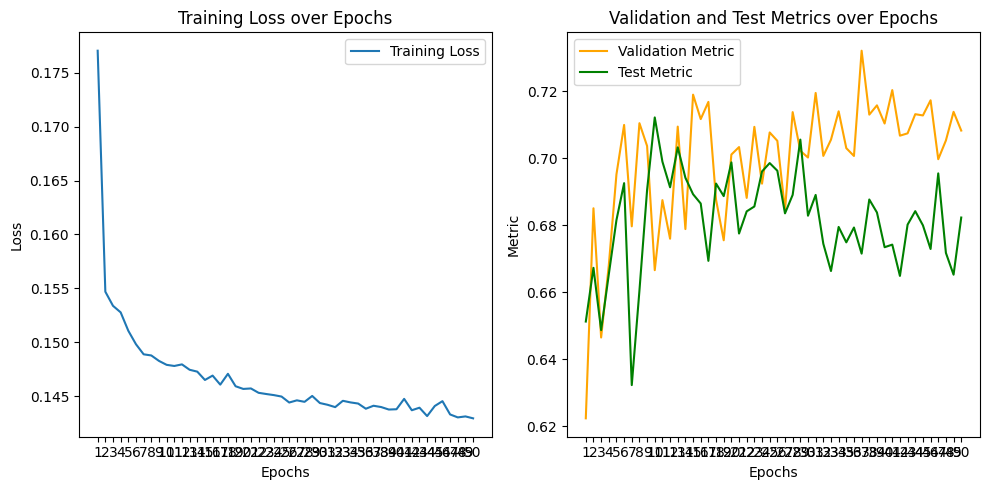

In [10]:
task_name = "ogbg-molhiv"
gnn_type = 'gin_attention'
val_metric_gin_at, test_metric_gin_at, curves_gin_at, model_gin_at = train_model_on_task(task_name, gnn_type = gnn_type, num_epochs = 50)
plot_curves(curves_gin_at)

100%|██████████| 129/129 [00:02<00:00, 52.02it/s]


{'Train Loss': 0.17790574586223468, 'Validation Metric': {'rocauc': 0.6440206741132667}, 'Test Metric': {'rocauc': 0.6274271422777573}}


100%|██████████| 129/129 [00:02<00:00, 46.51it/s]


{'Train Loss': 0.15828117964458013, 'Validation Metric': {'rocauc': 0.6538999730550656}, 'Test Metric': {'rocauc': 0.6206473666930609}}


100%|██████████| 129/129 [00:02<00:00, 54.23it/s]


{'Train Loss': 0.15741498470921847, 'Validation Metric': {'rocauc': 0.5287820889672742}, 'Test Metric': {'rocauc': 0.5950066629328492}}


100%|██████████| 129/129 [00:02<00:00, 54.06it/s]


{'Train Loss': 0.15927746045367885, 'Validation Metric': {'rocauc': 0.6274648491083676}, 'Test Metric': {'rocauc': 0.6079617219336024}}


100%|██████████| 129/129 [00:02<00:00, 43.20it/s]


{'Train Loss': 0.1579295415141637, 'Validation Metric': {'rocauc': 0.6100118802665099}, 'Test Metric': {'rocauc': 0.6568454392707468}}


100%|██████████| 129/129 [00:02<00:00, 52.83it/s]


{'Train Loss': 0.15714850028717947, 'Validation Metric': {'rocauc': 0.5780591686262981}, 'Test Metric': {'rocauc': 0.6591040769423898}}


100%|██████████| 129/129 [00:02<00:00, 52.64it/s]


{'Train Loss': 0.157820949571676, 'Validation Metric': {'rocauc': 0.5920536939055457}, 'Test Metric': {'rocauc': 0.6373616717201954}}


100%|██████████| 129/129 [00:03<00:00, 41.49it/s]


{'Train Loss': 0.15735602708292656, 'Validation Metric': {'rocauc': 0.5886656746031745}, 'Test Metric': {'rocauc': 0.6457637266073118}}


100%|██████████| 129/129 [00:02<00:00, 51.38it/s]


{'Train Loss': 0.15675815330606507, 'Validation Metric': {'rocauc': 0.583161865569273}, 'Test Metric': {'rocauc': 0.6478562737789453}}


100%|██████████| 129/129 [00:02<00:00, 53.93it/s]


{'Train Loss': 0.15759001130851816, 'Validation Metric': {'rocauc': 0.6019345238095237}, 'Test Metric': {'rocauc': 0.6342716159060623}}


100%|██████████| 129/129 [00:02<00:00, 43.90it/s]


{'Train Loss': 0.1578786259786786, 'Validation Metric': {'rocauc': 0.6382259822653341}, 'Test Metric': {'rocauc': 0.6529336217385426}}


100%|██████████| 129/129 [00:02<00:00, 54.25it/s]


{'Train Loss': 0.15751422279712585, 'Validation Metric': {'rocauc': 0.6099338011953752}, 'Test Metric': {'rocauc': 0.662760964869928}}


100%|██████████| 129/129 [00:02<00:00, 54.51it/s]


{'Train Loss': 0.15721922750839107, 'Validation Metric': {'rocauc': 0.606946893983931}, 'Test Metric': {'rocauc': 0.6607659475849281}}


100%|██████████| 129/129 [00:02<00:00, 44.29it/s]


{'Train Loss': 0.1570735715666335, 'Validation Metric': {'rocauc': 0.6328614907897316}, 'Test Metric': {'rocauc': 0.6562660538055969}}


100%|██████████| 129/129 [00:02<00:00, 54.43it/s]


{'Train Loss': 0.15695817451073316, 'Validation Metric': {'rocauc': 0.6201269473838917}, 'Test Metric': {'rocauc': 0.6615046640529944}}


100%|██████████| 129/129 [00:02<00:00, 54.84it/s]


{'Train Loss': 0.15714004277400997, 'Validation Metric': {'rocauc': 0.6137413041348228}, 'Test Metric': {'rocauc': 0.6078748141138299}}


100%|██████████| 129/129 [00:02<00:00, 50.26it/s]


{'Train Loss': 0.1579938885458067, 'Validation Metric': {'rocauc': 0.6209950029394473}, 'Test Metric': {'rocauc': 0.6620087294076749}}


100%|██████████| 129/129 [00:02<00:00, 49.98it/s]


{'Train Loss': 0.1574965495131077, 'Validation Metric': {'rocauc': 0.6303598985890653}, 'Test Metric': {'rocauc': 0.6555678943200911}}


100%|██████████| 129/129 [00:02<00:00, 52.94it/s]


{'Train Loss': 0.15706078329850331, 'Validation Metric': {'rocauc': 0.6274740348814423}, 'Test Metric': {'rocauc': 0.6501728499971031}}


100%|██████████| 129/129 [00:02<00:00, 49.08it/s]


{'Train Loss': 0.15682946994133198, 'Validation Metric': {'rocauc': 0.5900833455810308}, 'Test Metric': {'rocauc': 0.6439048649066224}}


100%|██████████| 129/129 [00:02<00:00, 47.05it/s]


{'Train Loss': 0.1569736675948513, 'Validation Metric': {'rocauc': 0.6090749314128944}, 'Test Metric': {'rocauc': 0.6617750439367311}}


100%|██████████| 129/129 [00:02<00:00, 54.14it/s]


{'Train Loss': 0.15695444473126077, 'Validation Metric': {'rocauc': 0.6125318440133255}, 'Test Metric': {'rocauc': 0.6589099828115645}}


100%|██████████| 129/129 [00:02<00:00, 56.16it/s]


{'Train Loss': 0.15680005546184972, 'Validation Metric': {'rocauc': 0.5869586517734666}, 'Test Metric': {'rocauc': 0.6335290368682285}}


100%|██████████| 129/129 [00:02<00:00, 55.21it/s]


{'Train Loss': 0.15728126059895411, 'Validation Metric': {'rocauc': 0.5982020380168529}, 'Test Metric': {'rocauc': 0.6297639969871957}}


100%|██████████| 129/129 [00:02<00:00, 44.67it/s]


{'Train Loss': 0.1562169109922775, 'Validation Metric': {'rocauc': 0.6092035322359397}, 'Test Metric': {'rocauc': 0.6215251356727631}}


100%|██████████| 129/129 [00:02<00:00, 55.87it/s]


{'Train Loss': 0.15583602323462015, 'Validation Metric': {'rocauc': 0.61553559180874}, 'Test Metric': {'rocauc': 0.6277796017690569}}


100%|██████████| 129/129 [00:02<00:00, 55.01it/s]


{'Train Loss': 0.15535490658311618, 'Validation Metric': {'rocauc': 0.6041452331961591}, 'Test Metric': {'rocauc': 0.6223208250449024}}


100%|██████████| 129/129 [00:02<00:00, 54.54it/s]


{'Train Loss': 0.15607132727010548, 'Validation Metric': {'rocauc': 0.5615676440329218}, 'Test Metric': {'rocauc': 0.6058691747619691}}


100%|██████████| 129/129 [00:02<00:00, 45.21it/s]


{'Train Loss': 0.15502777858207362, 'Validation Metric': {'rocauc': 0.6589506172839507}, 'Test Metric': {'rocauc': 0.6829177852024952}}


100%|██████████| 129/129 [00:02<00:00, 54.65it/s]


{'Train Loss': 0.15489005342495163, 'Validation Metric': {'rocauc': 0.6562331594160298}, 'Test Metric': {'rocauc': 0.6559116630294135}}


100%|██████████| 129/129 [00:02<00:00, 54.05it/s]


{'Train Loss': 0.1542537379883179, 'Validation Metric': {'rocauc': 0.656153549382716}, 'Test Metric': {'rocauc': 0.6683027868440874}}


100%|██████████| 129/129 [00:02<00:00, 50.95it/s]


{'Train Loss': 0.1542913100932905, 'Validation Metric': {'rocauc': 0.6581591098373506}, 'Test Metric': {'rocauc': 0.6733067459780991}}


100%|██████████| 129/129 [00:02<00:00, 47.12it/s]


{'Train Loss': 0.15385059316880617, 'Validation Metric': {'rocauc': 0.6756273883009996}, 'Test Metric': {'rocauc': 0.6652426659456537}}


100%|██████████| 129/129 [00:02<00:00, 55.87it/s]


{'Train Loss': 0.15387220641252367, 'Validation Metric': {'rocauc': 0.6596517979619831}, 'Test Metric': {'rocauc': 0.6664893103381679}}


100%|██████████| 129/129 [00:02<00:00, 48.65it/s]


{'Train Loss': 0.1532505816364601, 'Validation Metric': {'rocauc': 0.6710222540662356}, 'Test Metric': {'rocauc': 0.6694576952046196}}


100%|██████████| 129/129 [00:02<00:00, 47.62it/s]


{'Train Loss': 0.1535562109039233, 'Validation Metric': {'rocauc': 0.6448259602194787}, 'Test Metric': {'rocauc': 0.6562003901195466}}


100%|██████████| 129/129 [00:02<00:00, 54.13it/s]


{'Train Loss': 0.15376222746915558, 'Validation Metric': {'rocauc': 0.6559836125808347}, 'Test Metric': {'rocauc': 0.6841209756851233}}


100%|██████████| 129/129 [00:02<00:00, 48.33it/s]


{'Train Loss': 0.1546439092617167, 'Validation Metric': {'rocauc': 0.6628897829708015}, 'Test Metric': {'rocauc': 0.6733386121786824}}


100%|██████████| 129/129 [00:02<00:00, 44.78it/s]


{'Train Loss': 0.15378318720680922, 'Validation Metric': {'rocauc': 0.6565194493435235}, 'Test Metric': {'rocauc': 0.6743660557368817}}


100%|██████████| 129/129 [00:02<00:00, 45.63it/s]


{'Train Loss': 0.15397161410974866, 'Validation Metric': {'rocauc': 0.6652306241426611}, 'Test Metric': {'rocauc': 0.667172019544603}}


100%|██████████| 129/129 [00:02<00:00, 55.62it/s]


{'Train Loss': 0.15369804669805123, 'Validation Metric': {'rocauc': 0.6695004776601998}, 'Test Metric': {'rocauc': 0.6674926128353194}}


100%|██████████| 129/129 [00:02<00:00, 48.54it/s]


{'Train Loss': 0.15308315753466128, 'Validation Metric': {'rocauc': 0.6642783656672545}, 'Test Metric': {'rocauc': 0.6695957820738137}}


100%|██████████| 129/129 [00:02<00:00, 44.20it/s]


{'Train Loss': 0.15309600170024745, 'Validation Metric': {'rocauc': 0.6620446918479327}, 'Test Metric': {'rocauc': 0.6667625871492305}}


100%|██████████| 129/129 [00:02<00:00, 47.06it/s]


{'Train Loss': 0.15357201221327507, 'Validation Metric': {'rocauc': 0.6694698584166177}, 'Test Metric': {'rocauc': 0.667449158925433}}


100%|██████████| 129/129 [00:02<00:00, 46.85it/s]


{'Train Loss': 0.15304296231485606, 'Validation Metric': {'rocauc': 0.6601845728003135}, 'Test Metric': {'rocauc': 0.6586521562795727}}


100%|██████████| 129/129 [00:02<00:00, 44.79it/s]


{'Train Loss': 0.15289762492524234, 'Validation Metric': {'rocauc': 0.6525404786400157}, 'Test Metric': {'rocauc': 0.6609098283087738}}


100%|██████████| 129/129 [00:02<00:00, 48.71it/s]


{'Train Loss': 0.15320634792320814, 'Validation Metric': {'rocauc': 0.65948492308446}, 'Test Metric': {'rocauc': 0.6731483806176249}}


100%|██████████| 129/129 [00:02<00:00, 43.90it/s]


{'Train Loss': 0.1534349075269653, 'Validation Metric': {'rocauc': 0.6680215681951793}, 'Test Metric': {'rocauc': 0.6585768361691033}}


100%|██████████| 129/129 [00:02<00:00, 45.91it/s]


{'Train Loss': 0.15342070980665462, 'Validation Metric': {'rocauc': 0.6446131564765823}, 'Test Metric': {'rocauc': 0.6549952683520346}}


100%|██████████| 129/129 [00:02<00:00, 47.85it/s]


{'Train Loss': 0.15377168806470692, 'Validation Metric': {'rocauc': 0.6363811728395061}, 'Test Metric': {'rocauc': 0.6497556924621951}}
Best Validation Metric: 0.6756273883009996
Test Metric: 0.6652426659456537


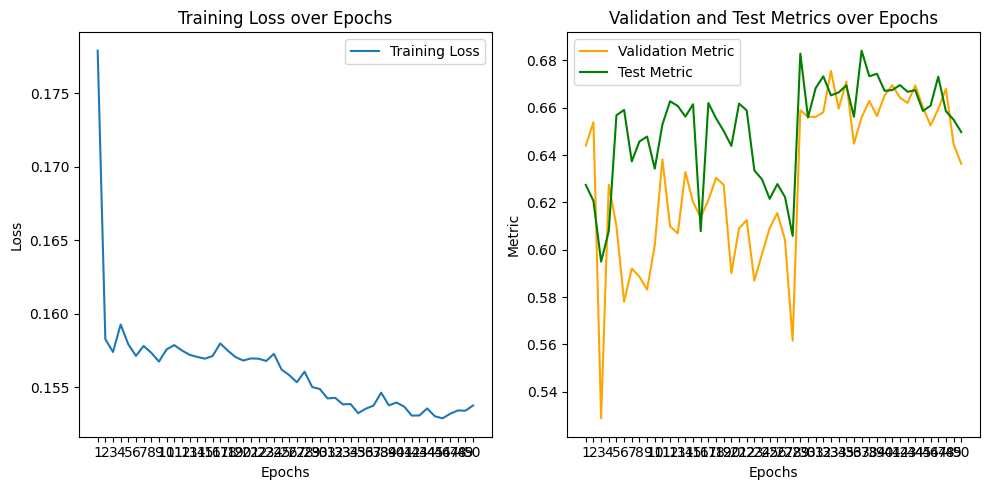

In [11]:
task_name = "ogbg-molhiv"
gnn_type = 'gin'
val_metric_gin, test_metric_gin, curves_gin, model_gin = train_model_on_task(task_name, gnn_type = gnn_type, num_epochs = 50)
plot_curves(curves_gin)